In [1]:

from pathlib import Path

root = Path("sampledata")

In [2]:
import torch
from torch.utils.data import DataLoader

image_path = root / "OriginalDataset"

mildDemented = image_path / "MildDemented"
moderateDemented = image_path / "ModerateDemented"
nonDemented = image_path / "NonDemented"
veryMildDemented = image_path / "VeryMildDemented"

In [3]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split

# 1. Define a composition of transformations - only resize here, as the processor handles ToTensor and Normalize
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 224x224 pixels
])

# 2. Load the dataset using ImageFolder and apply data_transforms
full_dataset = ImageFolder(root=image_path, transform=data_transforms)

total_size = len(full_dataset)
test_size = int(0.2 * total_size)
dev_size = total_size - test_size

dev_dataset, test_dataset = random_split(full_dataset,
                                  [dev_size, test_size],
                                  generator=torch.Generator().manual_seed(42))

print(f"Number of images in the dataset: {len(full_dataset)}")
print(f"Dev set: {len(dev_dataset)} Test set: {len(test_dataset)}")
print(f"Classes: {full_dataset.classes}")

Number of images in the dataset: 200
Dev set: 160 Test set: 40
Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [4]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold


# Made 2 splits for simplicity and faster execution in demo
num_splits = 2  
kfold = KFold(n_splits=num_splits, shuffle=True, random_state=42)

BATCH_SIZE = 32 # Define batch size for DataLoaders

# Lists to store training and validation DataLoaders for each fold
train_loaders = []
val_loaders = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(dev_dataset)):
    print(f"\n--- Creating DataLoader for Fold {fold+1}/{num_splits} ---")

    # Create Subset for training and validation data
    train_subset = Subset(dev_dataset, train_idx)
    val_subset = Subset(dev_dataset, val_idx)

    # Create DataLoaders for current fold
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

    # Store DataLoaders
    train_loaders.append(train_loader)
    val_loaders.append(val_loader)

    print(f"Fold {fold+1}: Training DataLoader has {len(train_loader)} batches (total {len(train_subset)} samples).")
    print(f"Fold {fold+1}: Validation DataLoader has {len(val_loader)} batches (total {len(val_subset)} samples).")

print("\nAll training and validation DataLoaders created for all folds.")


--- Creating DataLoader for Fold 1/2 ---
Fold 1: Training DataLoader has 3 batches (total 80 samples).
Fold 1: Validation DataLoader has 3 batches (total 80 samples).

--- Creating DataLoader for Fold 2/2 ---
Fold 2: Training DataLoader has 3 batches (total 80 samples).
Fold 2: Validation DataLoader has 3 batches (total 80 samples).

All training and validation DataLoaders created for all folds.


# Demo for ViT Provided for ease of runtime

In [5]:
import torch
from transformers import ViTForImageClassification, ViTImageProcessor, TrainingArguments, Trainer
from torch.utils.data import DataLoader
import numpy as np


# 1. Load the pretrained model and processor
model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)

num_labels = len(full_dataset.classes)



# 4. Custom dataset that works with JPG/PIL Images
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get PIL Image (converted from JPG) and label
        image, label = self.dataset[idx]

        # Processor handles PIL Images perfectly
        inputs = self.processor(images=image, return_tensors="pt")

        # Remove batch dimension and add label
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs['labels'] = label
        return inputs




c:\Users\User\Desktop\Grocery\184a-AD-Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import evaluate
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted', zero_division=0
    )

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

fold_results = []
for i in range(len(train_loaders)):
  print(f"Fold {i+1}")

  train_dataset = ImageDataset(train_loaders[i].dataset, processor)
  val_dataset = ImageDataset(val_loaders[i].dataset, processor)

  model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    ignore_mismatched_sizes=True  # For changing the classification head
  )
  

  training_args = TrainingArguments(
    eval_strategy="epoch", # every epoch to evaluate and save
    save_strategy="epoch",
    learning_rate=0.00002, # we used a low learning rate for convergence works better for ViT
    per_device_train_batch_size=16, # 16 batch size for optimal processing times
    per_device_eval_batch_size=16,
    num_train_epochs=5, # 5 epochs training
    weight_decay=0.01, #use regularization to prevent overfitting
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True, # or cuda
    remove_unused_columns=False,
  )

  accuracy_metric = evaluate.load("accuracy")

  # Trainer setup
  trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
  )

  trainer.train()

  results = trainer.evaluate()

  fold_results.append(results)
  print(f"Validation accuracy: {results['eval_accuracy']:.4f}")
  print(f"Validation loss: {results['eval_loss']:.4f}")
  print(f"Validation f1: {results['eval_f1']:.4f}")
  print(f"Validation precision: {results['eval_precision']:.4f}")
  print(f"Validation recall: {results['eval_recall']:.4f}")


Fold 1


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\User\Desktop\Grocery\184a-AD-Project\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.322931,0.387500,0.369356,0.387500,0.332960
2,No log,1.180345,0.487500,0.599347,0.487500,0.496290
3,No log,1.091555,0.587500,0.632572,0.587500,0.571601
4,No log,1.064864,0.612500,0.648444,0.612500,0.596355
5,No log,1.051124,0.612500,0.643910,0.612500,0.602022


c:\Users\User\Desktop\Grocery\184a-AD-Project\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\User\Desktop\Grocery\184a-AD-Project\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\User\Desktop\Grocery\184a-AD-Project\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\User\Desktop\Grocery\184a-AD-Project\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_m

Validation accuracy: 0.6125
Validation loss: 1.0649
Validation f1: 0.5964
Validation precision: 0.6484
Validation recall: 0.6125
Fold 2


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\User\Desktop\Grocery\184a-AD-Project\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.358053,0.312500,0.363239,0.312500,0.227171
2,No log,1.243284,0.437500,0.340568,0.437500,0.367385
3,No log,1.191207,0.512500,0.380186,0.512500,0.430202
4,No log,1.141690,0.575000,0.679620,0.575000,0.508842
5,No log,1.122465,0.600000,0.700563,0.600000,0.532901


c:\Users\User\Desktop\Grocery\184a-AD-Project\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\User\Desktop\Grocery\184a-AD-Project\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\User\Desktop\Grocery\184a-AD-Project\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\User\Desktop\Grocery\184a-AD-Project\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_m

Validation accuracy: 0.6000
Validation loss: 1.1225
Validation f1: 0.5329
Validation precision: 0.7006
Validation recall: 0.6000


In [7]:
#  FINAL TRAINING ON DEV SET 
final_train_dataset = ImageDataset(dev_dataset, processor)

#reinitialize model
final_model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    ignore_mismatched_sizes=True
)

final_training_args = TrainingArguments(
    eval_strategy="no",  #no validation during final training
    save_strategy="epoch",
    learning_rate=0.00002,
    per_device_train_batch_size=16,
    num_train_epochs=5,  #use same hyperparameters from best fold
    weight_decay=0.01,
    fp16=True,
    remove_unused_columns=False,
    report_to="none",
)

# Initialize Trainer
final_trainer = Trainer(
    model=final_model,
    args=final_training_args,
    train_dataset=final_train_dataset,
    compute_metrics=compute_metrics,
)

final_trainer.train()

#======== TEST ON HELD-OUT TEST SET ================
print(f"\n{'='*50}")
print("FINAL EVALUATION ON TEST SET")
print(f"{'='*50}")

test_dataset_wrapped = ImageDataset(test_dataset, processor)

test_results = final_trainer.evaluate(test_dataset_wrapped)

print(f"\n🎯 FINAL TEST RESULTS:")
print(f"Test Accuracy: {test_results['eval_accuracy']:.4f}")
print(f"Test Loss: {test_results['eval_loss']:.4f}")
print(f"Test F1: {test_results['eval_f1']:.4f}")
print(f"Test Precision: {test_results['eval_precision']:.4f}")
print(f"Test Recall: {test_results['eval_recall']:.4f}")


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\User\Desktop\Grocery\184a-AD-Project\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


c:\Users\User\Desktop\Grocery\184a-AD-Project\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\User\Desktop\Grocery\184a-AD-Project\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\User\Desktop\Grocery\184a-AD-Project\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\User\Desktop\Grocery\184a-AD-Project\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_m


FINAL EVALUATION ON TEST SET


c:\Users\User\Desktop\Grocery\184a-AD-Project\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



🎯 FINAL TEST RESULTS:
Test Accuracy: 0.4750
Test Loss: 1.0520
Test F1: 0.4229
Test Precision: 0.4523
Test Recall: 0.4750


# Inference for both ViT and EfficientNet from best runs

In [ ]:
from transformers import ViTForImageClassification, ViTImageProcessor

# Load the saved ViT model and processor
vit_model = ViTForImageClassification.from_pretrained("./vit-best")
vit_processor = ViTImageProcessor.from_pretrained("./vit-best")

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vit_model = vit_model.to(device)
vit_model.eval()

In [ ]:
from transformers import EfficientNetForImageClassification, EfficientNetImageProcessor

# Load the saved EfficientNet model 
efficientnet_model = EfficientNetForImageClassification.from_pretrained("./effnet-best")
# Load processor from 
efficientnet_processor = EfficientNetImageProcessor.from_pretrained("google/efficientnet-b0")

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
efficientnet_model = efficientnet_model.to(device)
efficientnet_model.eval()

EfficientNetForImageClassification(
  (efficientnet): EfficientNetModel(
    (embeddings): EfficientNetEmbeddings(
      (padding): ZeroPad2d((0, 1, 0, 1))
      (convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=valid, bias=False)
      (batchnorm): BatchNorm2d(32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (activation): SiLU()
    )
    (encoder): EfficientNetEncoder(
      (blocks): ModuleList(
        (0): EfficientNetBlock(
          (depthwise_conv): EfficientNetDepthwiseLayer(
            (depthwise_conv_pad): ZeroPad2d((0, 1, 0, 1))
            (depthwise_conv): EfficientNetDepthwiseConv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=32, bias=False)
            (depthwise_norm): BatchNorm2d(32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
            (depthwise_act): SiLU()
          )
          (squeeze_excite): EfficientNetSqueezeExciteLayer(
            (squeeze): AdaptiveAvgPool2d(output

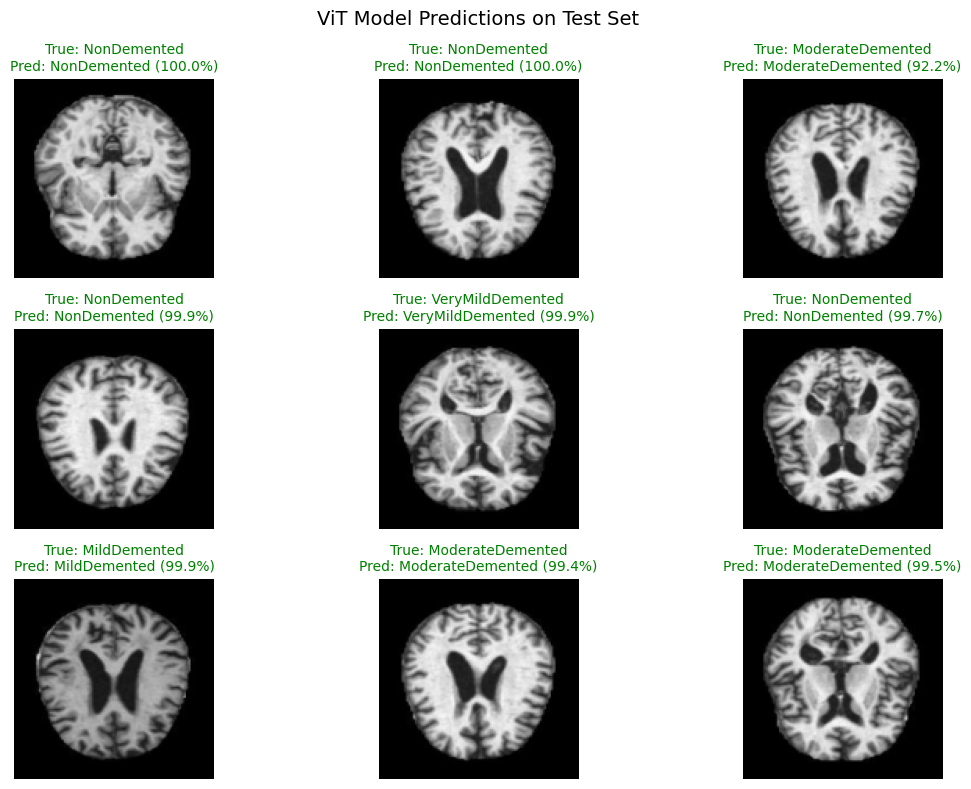

In [ ]:
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F

# Get some random samples from the test set
num_samples = 9
indices = random.sample(range(len(full_dataset)), num_samples)

# Class names
class_names = full_dataset.classes

fig, axes = plt.subplots(3, 3, figsize=(12, 8))
axes = axes.flatten()

for i, idx in enumerate(indices):
    # Get image and true label
    image, true_label = full_dataset[idx]
    
    # Prepare image for model
    inputs = vit_processor(images=image, return_tensors="pt").to(device)
    
    # Make prediction
    with torch.no_grad():
        outputs = vit_model(**inputs)
        # Get probabilities using softmax
        probs = F.softmax(outputs.logits, dim=-1)
        confidence, predicted_class = probs.max(-1)
        confidence = confidence.item() * 100  # Convert to percentage
        predicted_class = predicted_class.item()
    
    # Get class names
    true_class = class_names[true_label]
    pred_class = class_names[predicted_class]
    
    # Display
    axes[i].imshow(image)
    axes[i].axis('off')
    
    # Color code: green if correct, red if wrong
    color = 'green' if true_label == predicted_class else 'red'
    # Set title and caption stuff
    axes[i].set_title(f"True: {true_class}\nPred: {pred_class} ({confidence:.1f}%)", color=color, fontsize=10)

plt.suptitle("ViT Model Predictions on Test Set", fontsize=14)
plt.tight_layout()
plt.show()

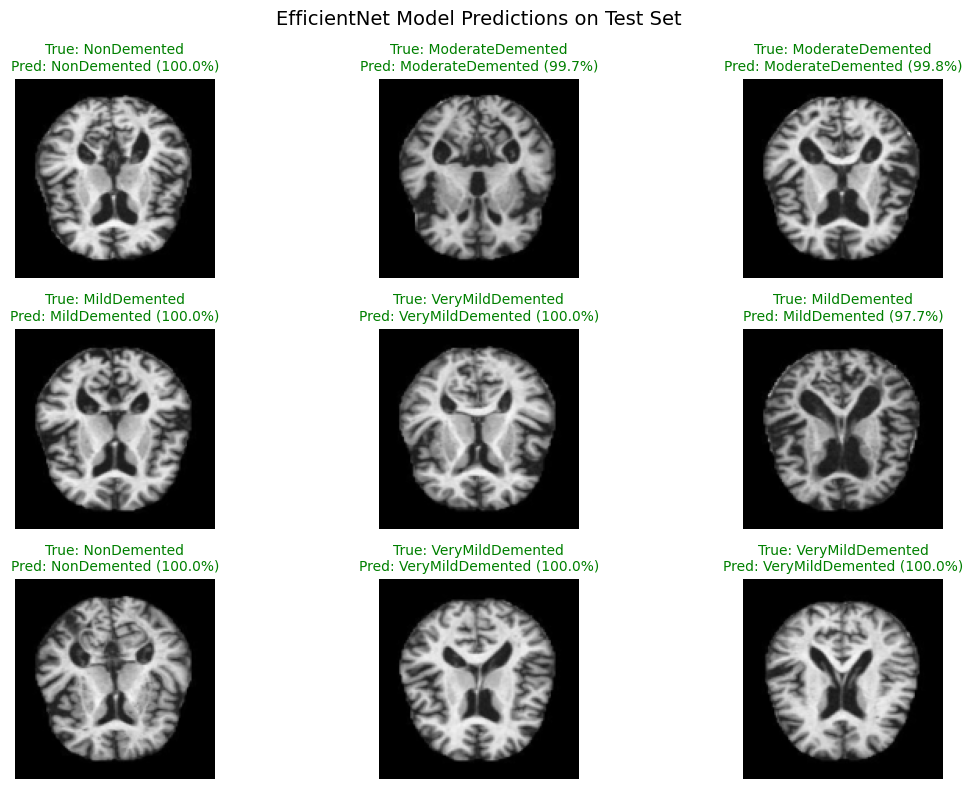

In [ ]:
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F

# Get some random samples from the test set
num_samples = 9
indices = random.sample(range(len(full_dataset)), num_samples)

# Class names
class_names = full_dataset.classes

fig, axes = plt.subplots(3, 3, figsize=(12, 8))
axes = axes.flatten()

for i, idx in enumerate(indices):
    # Get image and true label
    image, true_label = full_dataset[idx]
    
    # Prepare image for model
    inputs = efficientnet_processor(images=image, return_tensors="pt").to(device)
    
    # Make prediction
    with torch.no_grad():
        outputs = efficientnet_model(**inputs)
        # Get probabilities using softmax
        probs = F.softmax(outputs.logits, dim=-1)
        confidence, predicted_class = probs.max(-1)
        confidence = confidence.item() * 100  # Convert to percentage
        predicted_class = predicted_class.item()
    
    # Get class names
    true_class = class_names[true_label]
    pred_class = class_names[predicted_class]
    
    # Display
    axes[i].imshow(image)
    axes[i].axis('off')
    
    # Color code: green if correct, red if wrong
    color = 'green' if true_label == predicted_class else 'red'
    # Set title and caption stuff
    axes[i].set_title(f"True: {true_class}\nPred: {pred_class} ({confidence:.1f}%)", color=color, fontsize=10)

plt.suptitle("EfficientNet Model Predictions on Test Set", fontsize=14)
plt.tight_layout()
plt.show()